In [89]:
import sys
sys.path.append("../")
sys.path.append("../diffusion")

import utils
import matplotlib.pyplot as plt
from pathlib import Path
import os
import torch
from torch_geometric.data import Data
import pickle
import collections
import re

DEVICE="cuda:0"

def plot_set(data_set, nrows = 3, ncols = 6, scale_factor = 1.0):
    fig, axes = plt.subplots(nrows, ncols)
    fig.set_size_inches(scale_factor*ncols*2, scale_factor*nrows*2)
    for i, (x, cond) in enumerate(data_set):
        img = utils.visualize_placement(x, cond)
        ax = axes[i//ncols][i%ncols] if nrows > 1 else axes[i%ncols]
        ax.imshow(img)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

def preprocess_placement(x, cond, scale=1):
    if len(cond.chip_size) == 4: # chip_size is [x_start, y_start, x_end, y_end]
        chip_size = (cond.chip_size[2] - cond.chip_size[0], cond.chip_size[3] - cond.chip_size[1])
        chip_offset = (cond.chip_size[0], cond.chip_size[1])
    else:
        chip_size = (cond.chip_size[0], cond.chip_size[1])
        chip_offset = (0, 0)
    chip_size = torch.tensor(chip_size, dtype = torch.float32).view(1, 2)
    chip_offset = torch.tensor(chip_offset, dtype = torch.float32).view(1, 2)
    x = (torch.tensor(x, dtype=torch.float32) - chip_offset)/scale
    x = 2 * (x / chip_size) - 1
    # use center of instance as coordinate point and reference for terminal
    x = x + cond.x/2
    return x

def eval_set(data_set, eval_fn, **kwargs):
    return [eval_fn(x, cond, normalized_hpwl=False, **kwargs)[1] for (x, cond) in data_set]

def plot_and_eval_set(data_set, eval_fn, nrows = 3, ncols = 6, scale_factor = 1.0, title=None):
    fig, axes = plt.subplots(nrows, ncols)
    fig.set_size_inches(scale_factor*ncols*2, scale_factor*nrows*2 + 0.2)
    if title:
        fig.suptitle(title)
    for i, (x, cond) in enumerate(data_set):
        img = utils.visualize_placement(x, cond)
        ax = axes[i//ncols][i%ncols] if nrows > 1 else axes[i%ncols]
        ax.imshow(img)
        ax.set_xticks([])
        ax.set_yticks([])
        metric = eval_fn(x, cond, normalized_hpwl=False)[1]
        ax.set_title(f"{metric:.0f}")
    plt.show()

def plot_and_print_metrics(metrics, images, nrows = 3, ncols = 6, scale_factor = 1.0, title=None):
    fig, axes = plt.subplots(nrows, ncols)
    fig.set_size_inches(scale_factor*ncols*2, scale_factor*nrows*2 + 0.2)
    if title:
        fig.suptitle(title)
    for i, (metric, image) in enumerate(zip(metrics, images)):
        ax = axes[i//ncols][i%ncols] if nrows > 1 else axes[i%ncols]
        ax.imshow(image.T, origin="lower", cmap="gray_r")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"{metric:.5g}")
    plt.show()

def from_pl(base_path, cond, circuit_name="adaptec1"):
    # converts placements to a pl output, produces data as torch (V, 2) tensor
    V = cond.num_nodes
    data = torch.zeros((V,2), dtype=torch.float32)
    fixed_mask = torch.zeros((V,), dtype=bool)
    original_pl_file = os.path.join(base_path, circuit_name, f"{circuit_name}_placed.pl")
    with open(original_pl_file, "r") as f:
        i = 0
        for line in f.readlines():
            line_stripped = line.strip()
            if not line_stripped.startswith("o") and not line_stripped.startswith("p"):
                continue # not relevant to placement
            else:
                line_split = line_stripped.split()
                obj_name = line_split[0]
                obj_index = cond.name_index_mapping[obj_name]
                data[obj_index, 0] = float(line_split[1]) 
                data[obj_index, 1] = float(line_split[2])
                if len(line_split) > 5:
                    if "/FIXED" in line_stripped:
                        fixed_mask[obj_index] = True
                    else:
                        fixed_mask[obj_index] = False
                else:
                    if "/FIXED" in line_stripped: # unexpected
                        import ipdb; ipdb.set_trace()
                    fixed_mask[obj_index] = False
                i += 1
    data = data / 1000 # TRICK FOR ISPD
    return data, fixed_mask

def load_ispd_placements(base_dir, graph_dataset):
    # Generates dataset of (x, cond) using placements from base_dir and cond from graph_dataset
    ispd_mapping = [f"adaptec{i+1}" for i in range(4)] + [f"bigblue{i+1}" for i in range(4)] # maps file_idx to placement name
    out_set = []
    for _, cond in graph_dataset:
        circuit_name = ispd_mapping[cond.file_idx]
        load_path = os.path.join(base_dir, circuit_name, f"{circuit_name}_placed.pl")
        if not os.path.exists(load_path):
            print(f"skipping {circuit_name}, {load_path} not found")
            continue
        placement, fixed_mask = from_pl(base_dir, cond=cond, circuit_name=circuit_name)
        cond["fixed_mask"] = fixed_mask
        placement = preprocess_placement(placement, cond)
        out_set.append((placement, cond))
    return out_set

## Loading and Parsing

In [90]:
ISPD_CHIP_SIZES = {
    0: [0.459, 0.459, 0.459 + 10692/1000, 0.459 + 12*890/1000], # adaptec1
    1: [0.609, 0.616, 0.609 + 14054/1000, 0.616 + 12*1170/1000],
    2: [0.036, 0.058, 0.036 + 23190/1000, 23386/1000],
    3: [0.036, 0.058, 0.036 + 23190/1000, 23386/1000],
    4: [0.459, 0.459, 0.459 + 10692/1000, 11139/1000], # bigblue1 
    5: [0.036, 0.076, 0.036 + 18690/1000, 18868/1000],
    6: [0.036, 0.076, 0.036 + 27690/1000, 27868/1000],
    7: [0.036, 0.058, 0.036 + 32190/1000, 32386/1000],
}

class Pin():
    def __init__(self, id, obj_name, offset):
        self.obj_name = obj_name
        self.id = id
        self.offset = offset
    def __str__(self):
        return f"Pin(id:{self.id}, obj:{self.obj_name}, {self.offset})"
    def __repr__(self):
        return self.__str__()

def flip_stack(data):
    """
    data is tensor (B, N, ...)
    flips along N axis, then appends along B axis
    Output is shaped (2B, N, ...)
    """
    return torch.concatenate((data, torch.flip(data, dims=(1,))), dim=0)

def parse_bookshelf(nodes_path, nets_path, pl_path, verbose=False, warn=False):
    """
    Parses bookshelf circuit and placement and generates (x, cond) python objects

    Returns:
    - x: (V, 2) tensor with placement of objects (measured to bottom left) in non-normalized units
    - cond: torch_geometric Data object containing the following keys:
        - x: (V, 2) tensor containing sizes of objects
        - is_ports: (V,) bool tensor
        - is_macros: (V,) bool tensor
        - edge_index: (2, E) int64 tensor
        - edge_attr: (E, 4) tensor with pin offsets for start and end pins, measured from bottom left of object
        - edge_pin_id: (E, 2) locally unique pin id (each pin has id unique among pins on the same object)
        - name_index_mapping: {str : int} maps object names to index in tensors
        NOTE: chip_size needs to be specified externally
    """

    SCALING_UNITS = 1000
    print_fn = print if verbose else lambda x: 0
    warn_fn = print if warn else lambda x: 0

    # Ingest Placement file
    with open(pl_path, 'r') as pl_file:
        pl_file_data = pl_file.readlines()
    placement_line_pattern = re.compile(r"^\s*(\S+)\s+(\d+(?:\.\d*)?)\s+(\d+(?:\.\d+)?)\s*:\s*(F?N|S|E|W)\s*(/FIXED)?\s*$")
    placement_dict = {"obj_names": [], "positions": [], "is_fixed": []}
    for pl_line in pl_file_data:
        match = re.match(placement_line_pattern, pl_line)
        if match: # valid placement line
            placement_dict["obj_names"].append(match[1])
            placement_dict["positions"].append((float(match[2]), float(match[3])))
            assert match[4] == "N", "non-North orientations not supported"
            placement_dict["is_fixed"].append(match[5] is not None) # unused for ISPD
    print_fn("num objects:", len(placement_dict["positions"]))

    # Ingest Nodes file
    with open(nodes_path, 'r') as nodes_file:
        nodes_file_data = nodes_file.readlines()
    node_line_pattern = re.compile(r"^\s*(\S+)\s+(\d+(?:\.\d+)?)\s+(\d+(?:\.\d*)?)\s+(terminal)?$")
    node_size_dict = {} # name: size
    node_macro_dict = {} # name: is_macro
    for node_line in nodes_file_data:
        match = re.match(node_line_pattern, node_line)
        if match: # valid node data line
            node_name = match[1]
            assert node_name not in node_size_dict, "duplicate node names detected"
            
            node_size_dict[node_name] = (float(match[2]), float(match[3]))
            node_macro_dict[node_name] = (match[4] is not None)
    print_fn("num unique objects:", len(node_size_dict))
    print_fn("num macros:", sum(node_macro_dict.values()))

    # Ingest Nets file
    with open(nets_path, 'r') as nets_file:
        nets_file_data = nets_file.readlines()
    
    # header for each net
    net_header_pattern = re.compile(r"^\s*NetDegree\s*:\s*(\d+)\s+(\S+)\s*$") 
    # pin data in a net
    net_line_pattern = re.compile(r"^\s*(\S+)\s+(I|O)\s*:\s*(-?\d+(?:\.\d+)?)\s+(-?\d+(?:\.\d+)?)\s*$")
    
    nets_started = False
    line_num = 0
    nets = []
    one_deg_nets = 0
    while line_num < len(nets_file_data):
        nets_line = nets_file_data[line_num]
        header_match = re.match(net_header_pattern, nets_line)
        line_num += 1
        if header_match: # start looking for nets
            net_degree = int(header_match[1])
            if net_degree < 2:
                one_deg_nets += 1
                line_num += net_degree
                continue
            net_name = header_match[2]
            current_net = {"inputs": []}
            for i in range(net_degree):
                net_line_match = re.match(net_line_pattern, nets_file_data[line_num])
                line_num += 1
                assert net_line_match is not None, f"{net_name} should have {net_degree} pins but found {i}"
                new_pin = Pin(
                    id = line_num,
                    obj_name = net_line_match[1],
                    offset = (float(net_line_match[3]), float(net_line_match[4])),
                    )
                if net_line_match[2] == "I":
                    current_net["inputs"].append(new_pin)
                else: # this is the source
                    if "output" not in current_net: 
                        current_net["output"] = new_pin
                    else:
                        warn_fn(f"WARNING: multiple output pins detected in net {net_name}, using first output pin...")
                        current_net["inputs"].append(new_pin)
            if "output" not in current_net: 
                warn_fn(f"WARNING: no output pins detected in {net_name}, using last pin...")
                current_net["output"] = current_net["inputs"].pop()
            nets.append(current_net)
        else:
            assert not nets_started, f"Expected contiguous block of nets, found {nets_line}, or previous net has more pins than header specifies."
    print_fn("nets and pins after removing one-deg nets", len(nets), sum([len(n["inputs"])+1 for n in nets]))
    print_fn("original nets and pins", one_deg_nets+len(nets), one_deg_nets+sum([len(n["inputs"])+1 for n in nets]))

    # Generate per-node outputs
    x = torch.tensor(placement_dict["positions"]) # (V, 2)
    is_macros = []
    cond_x = []
    name_index_mapping = {} # used to get object index from object_name
    for obj_idx, obj_name in enumerate(placement_dict["obj_names"]): # preserve object order
        is_macros.append(node_macro_dict[obj_name])
        cond_x.append(node_size_dict[obj_name])
        name_index_mapping[obj_name] = obj_idx
    is_macros = torch.tensor(is_macros) # (V,) bool
    is_ports = torch.zeros_like(is_macros) # for ispd, no ports
    cond_x = torch.tensor(cond_x) # (V, 2)
    # Generate per-edge outputs
    edge_indices = []
    edge_attrs = []
    edge_pin_ids = []
    for net in nets:
        net_source_pin = net["output"]
        for sink_pin in net["inputs"]:
            edge_indices.append(
                (name_index_mapping[net_source_pin.obj_name], name_index_mapping[sink_pin.obj_name])
            )
            edge_attrs.append((*net_source_pin.offset, *sink_pin.offset))
            edge_pin_ids.append((net_source_pin.id, sink_pin.id))
    edge_index_unique = torch.tensor(edge_indices, dtype=torch.int64) # (E_u, 2)
    edge_attr_unique = torch.tensor(edge_attrs) # (E_u, 4)
    edge_pin_id_unique = torch.tensor(edge_pin_ids, dtype=torch.int64) # (E_u, 2)

    # edge attribute should be measured wrt. bottom left
    u_shape = cond_x[edge_index_unique[:,0]]
    v_shape = cond_x[edge_index_unique[:,1]]
    edge_attr_unique[:,:2] = edge_attr_unique[:,:2] + u_shape/2
    edge_attr_unique[:,2:4] = edge_attr_unique[:,2:4] + v_shape/2
    
    E_u, _ = edge_index_unique.shape
    edge_index = flip_stack(edge_index_unique).T
    edge_attr = flip_stack(edge_attr_unique.view(E_u, 2, 2)).view(E_u*2, 4)
    edge_pin_id = flip_stack(edge_pin_id_unique)

    cond = Data(
        x = cond_x/SCALING_UNITS,
        edge_index = edge_index,
        edge_attr = edge_attr/SCALING_UNITS,
        edge_pin_id = edge_pin_id,
        is_ports = is_ports,
        is_macros = is_macros,
        name_index_mapping = name_index_mapping,
    )
    return x/SCALING_UNITS, cond

### Converting Simple Benchmark

num objects: 3
num unique objects: 3
num macros: 2
nets and pins after removing one-deg nets 3 8
original nets and pins 3 8
1 2
torch.Size([3, 2]) Data(x=[3, 2], edge_index=[2, 10], edge_attr=[10, 4], edge_pin_id=[10, 2], is_ports=[3], is_macros=[3], chip_size=[4])
HPWL 0.27299997210502625
Macro HPWL 0.08500000089406967


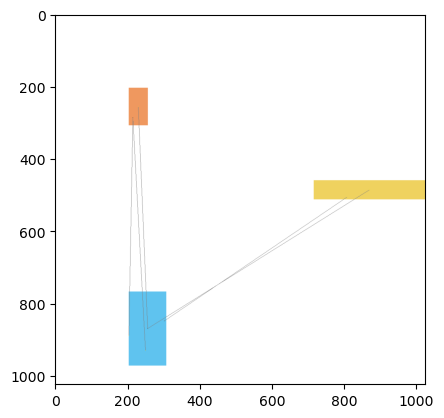

In [50]:
benchmark_name = "simple"
circuit_name = "simple1"
nodes_path = f"../benchmarks/{benchmark_name}/{circuit_name}/{circuit_name}.nodes"
nets_path = f"../benchmarks/{benchmark_name}/{circuit_name}/{circuit_name}.nets"
pl_path = f"../benchmarks/{benchmark_name}/{circuit_name}/{circuit_name}.pl"

x, cond = parse_bookshelf(nodes_path, nets_path, pl_path, verbose=True)
cond["chip_size"] = [0, 0, 0.1, 0.1]

x, cond = utils.preprocess_graph(x, cond, chip_size=(0.1, 0.1))

print(x.shape, cond)
image1 = utils.visualize_placement(x, cond, plot_pins=True, plot_edges=True, img_size=(1024, 1024))
utils.debug_plot_img(image1, name=f"img_{circuit_name}")

print("HPWL", utils.hpwl_fast(x, cond, normalized_hpwl=False)[1])
print("Macro HPWL", utils.macro_hpwl(x, cond, normalized_hpwl=False)[1])

### Converting ISPD Benchmark

In [91]:
ispd_names = [f"adaptec{i+1}" for i in range(4)] + [f"bigblue{i+1}" for i in range(4)]
benchmark_path = "../benchmarks/ispd2005/"

output_dir = "../datasets/graph/ispd2005-s0" # s for self-converted
os.makedirs(output_dir, exist_ok=True)

for idx, name in enumerate(ispd_names):
    print(f"CONVERTING {name}...")
    nodes_path = os.path.join(benchmark_path, name, f"{name}.nodes")
    nets_path = os.path.join(benchmark_path, name, f"{name}.nets")
    pl_path = os.path.join(benchmark_path, name, f"{name}.pl")
    x, cond = parse_bookshelf(nodes_path, nets_path, pl_path, verbose=True, warn=False)
    cond.chip_size = ISPD_CHIP_SIZES[idx]
    
    cond_path = os.path.join(output_dir, f"graph{idx}.pickle")
    x_path = os.path.join(output_dir, f"output{idx}.pickle")
    
    with open(cond_path, 'wb') as f:
        pickle.dump(cond, f)
    with open(x_path, 'wb') as f:
        pickle.dump(x, f)
    print(f"saved graph to {cond_path} and placement to {x_path}")


CONVERTING adaptec1...
num objects: 211447
num unique objects: 211447
num macros: 543
nets and pins after removing one-deg nets 219794 942705
original nets and pins 221142 944053
saved graph to ../datasets/graph/ispd2005-s0/graph0.pickle and placement to ../datasets/graph/ispd2005-s0/output0.pickle
CONVERTING adaptec2...
num objects: 255023
num unique objects: 255023
num macros: 566
nets and pins after removing one-deg nets 260159 1063632
original nets and pins 266009 1069482
saved graph to ../datasets/graph/ispd2005-s0/graph1.pickle and placement to ../datasets/graph/ispd2005-s0/output1.pickle
CONVERTING adaptec3...
num objects: 451650
num unique objects: 451650
num macros: 723
nets and pins after removing one-deg nets 466295 1874576
original nets and pins 466758 1875039
saved graph to ../datasets/graph/ispd2005-s0/graph2.pickle and placement to ../datasets/graph/ispd2005-s0/output2.pickle
CONVERTING adaptec4...
num objects: 496045
num unique objects: 496045
num macros: 1329
nets and 

## Checking Results

In [102]:
task = "ispd2005-s0"
placement_name = "chipformer_validation"
# placement_name = None
placement_dir = f"placements/{placement_name}/ispd2005" if placement_name is not None else None
train_set, val_set = utils.load_graph_data_with_config(
    task, 
    train_data_limit = None, 
    val_data_limit = None,
    )

print("Train set and val set sizes: ", len(train_set), len(val_set))

if placement_dir is None:
    placed_set = val_set
else:
    placed_set = load_ispd_placements(placement_dir, val_set)
placed_set = [(x.to(device=DEVICE), cond.to(device=DEVICE)) for x, cond in placed_set]
mask_overlap = [(cond.fixed_mask & cond.is_macros).sum().cpu().item() for (_, cond) in placed_set]
# placed_set = [utils.remove_non_macros(x, cond) for x, cond in placed_set] # This step is not strictly necessary, just speeds up plotting

num_objects = [cond.num_nodes for (x, cond) in placed_set]
num_placement_objects = [x.shape[0] for (x, cond) in placed_set]
num_edges = [cond.num_edges for (x, cond) in placed_set]
num_macros = [cond.is_macros.sum().cpu().item() for (x, cond) in placed_set]
num_ports = [cond.is_ports.sum().cpu().item() for (x, cond) in placed_set]
num_fixed_in_pl = [cond.fixed_mask.sum().cpu().item() for (x, cond) in placed_set] if placement_dir is not None else None
print("# objects:", num_objects)
print("# objects in placement:", num_placement_objects)
print("# edges:", num_edges)
print("# macros:", num_macros)
print("# ports:", num_ports)
print("# fixed in pl:", num_fixed_in_pl)
print("mask overlap:", mask_overlap)
# print(placed_set[0][1])

# plot_set(placed_set, nrows=1, ncols=2, scale_factor=4)

Train set and val set sizes:  0 8
# objects: [211447, 255023, 451650, 496045, 278164, 557866, 1096812, 2177353]
# objects in placement: [211447, 255023, 451650, 496045, 278164, 557866, 1096812, 2177353]
# edges: [1445822, 1606946, 2816562, 2792938, 1720424, 3090094, 5420096, 13340384]
# macros: [543, 566, 723, 1329, 560, 23084, 1298, 8170]
# ports: [0, 0, 0, 0, 0, 0, 0, 0]
# fixed in pl: [543, 566, 723, 1329, 560, 23084, 1298, 8170]
mask overlap: [543, 566, 723, 1329, 560, 23084, 1298, 8170]


In [101]:
print(task, placement_name)
full_hpwl = eval_set(placed_set, eval_fn=utils.hpwl_fast)
hpwl_results = eval_set(placed_set, eval_fn=utils.macro_hpwl)
print("Macro HPWL:", hpwl_results)
print("HPWL:", full_hpwl)

# for i in range(2):
#     image1 = utils.visualize_placement(*placed_set[i], plot_pins=True, img_size=(2048, 2048))
#     utils.debug_plot_img(image1, name=f"img{i}")


ispd2005-s0 chipformer_validation
Macro HPWL: [1017.4408569335938, 6492.77587890625, 7645.39013671875, 6741.654296875, 335.343505859375, 20402.7265625, 8278.671875, 134936.65625]
HPWL: [106464.1953125, 109030.3125, 415542.3125, 462201.5625, 76343.6015625, 635635.5, 602586.125, 1939978.0]
